<a href="https://colab.research.google.com/github/knoppin1/DATA-690-WANG/blob/master/Assignment_09/Assignment_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Import Necessary Files

In [1]:
import os
from random import *
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

# Libraries below are used in retrieving the zip file
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# 2 - Read Election Data 

2020 Presidential Candidate County Level Data 

- File is available from Kaggle  
- https://www.kaggle.com/unanimad/us-election-2020?select=president_county_candidate.csv

This attempt below to automatically download the file didn't work...
````
!pip install wget
import wget
url = 'https://www.kaggle.com/unanimad/us-election-2020/president_county_candidate.csv'
filename = wget.download(url)
````

So, manually download "*president_county_candidate.csv*" file from Kaggle and load it into Jupyter session.

In [2]:
filename = 'president_county_candidate.csv'

Read the CSV file

In [3]:
df = pd.read_csv(filename, header=0, sep=',', error_bad_lines=False) 
df.shape

(31407, 6)

In [4]:
df.head()

,state,county,candidate,party,total_votes,won
0,Delaware,Kent County,Joe Biden,DEM,44552,True
1,Delaware,Kent County,Donald Trump,REP,41009,False
2,Delaware,Kent County,Jo Jorgensen,LIB,1044,False
3,Delaware,Kent County,Howie Hawkins,GRN,420,False
4,Delaware,New Castle County,Joe Biden,DEM,195034,True


In [5]:
df.tail()

,state,county,candidate,party,total_votes,won
31402,Arizona,Maricopa County,Donald Trump,REP,995665,False
31403,Arizona,Maricopa County,Jo Jorgensen,LIB,31705,False
31404,Arizona,Mohave County,Donald Trump,REP,78535,True
31405,Arizona,Mohave County,Joe Biden,DEM,24831,False
31406,Arizona,Mohave County,Jo Jorgensen,LIB,1302,False


# 3 - Clean Election Data


## 3.1 - Display summary information



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31407 entries, 0 to 31406
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        31407 non-null  object
 1   county       31407 non-null  object
 2   candidate    31407 non-null  object
 3   party        31407 non-null  object
 4   total_votes  31407 non-null  int64 
 5   won          31407 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.2+ MB


All columns have correct data types.

In [7]:
df.describe(include =  'all')

,state,county,candidate,party,total_votes,won
count,31407,31407,31407,31407,3.140700e+04,31407
unique,51,3007,38,26,NaN,2
top,Vermont,Washington County,Joe Biden,LIB,NaN,False
freq,5412,180,4633,4633,NaN,26774
mean,NaN,NaN,NaN,NaN,5.016970e+03,NaN
std,NaN,NaN,NaN,NaN,3.574530e+04,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,3.000000e+00,NaN
50%,NaN,NaN,NaN,NaN,3.500000e+01,NaN
75%,NaN,NaN,NaN,NaN,8.090000e+02,NaN


Notes:
- There are 31,407 records each representing voting results by candidate for each state/county.  
- There were 38 total candidates, but not all candidates were on each ballot. Only Donald Trump and Joe Biden are relevant to this study.
- There are 51 states (DC is counted as a state in the data set because it has electoral votes)
- 3007 counties are represented (DC has wards included as counties in the data)
- All counties have declared a winner

## 3.2 - Check for Missing Data

In [8]:
df.isnull().sum()

state          0
county         0
candidate      0
party          0
total_votes    0
won            0
dtype: int64

There are no missing records.

## 3.3 - Remove Duplicate Rows

Find duplicates


In [9]:
dups = df.duplicated(keep=False)
dups

0        False
1        False
2        False
3        False
4        False
         ...  
31402    False
31403    False
31404    False
31405    False
31406    False
Length: 31407, dtype: bool

Get index of any duplicates

Ref: https://stackoverflow.com/questions/52173161/getting-a-list-of-indices-where-pandas-boolean-series-is-true

In [10]:
[i for i in dups.index if dups[i]]

[]

No duplicates exist.  

In [11]:
df.drop_duplicates(inplace=True)
df.shape

(31407, 6)

Check specifically for candidate duplicate entries in any state/county 

In [12]:
dups = df.duplicated(['state','county','candidate'],keep=False)
dups

0        False
1        False
2        False
3        False
4        False
         ...  
31402    False
31403    False
31404    False
31405    False
31406    False
Length: 31407, dtype: bool

In [13]:
[i for i in dups.index if dups[i]]

[]

No duplicate entries for a candidate in any state/county

## 3.4 - Remove State/County Records Without Votes

In [14]:
state_county_totals = df.groupby(by=['state','county']).sum('total_votes').sort_values('total_votes')
state_county_totals.reset_index(level=['state','county'], inplace=True)
state_county_totals

,state,county,total_votes,won
0,Maine,Sandy River Plt.,0,1
1,Maine,Blaine,0,1
2,Illinois,Hardin County,0,1
3,Maine,Oxford Cty Townships,0,1
4,Massachusetts,Clarksburg,0,1
...,...,...,...,...
4628,California,San Diego County,1600272,1
4629,Texas,Harris County,1640818,1
4630,Arizona,Maricopa County,2068144,1
4631,Illinois,Cook County,2306675,1


Get state/counties that didn't submit votes

In [15]:
no_votes = state_county_totals.query('total_votes == 0')
no_votes

,state,county,total_votes,won
0,Maine,Sandy River Plt.,0,1
1,Maine,Blaine,0,1
2,Illinois,Hardin County,0,1
3,Maine,Oxford Cty Townships,0,1
4,Massachusetts,Clarksburg,0,1
...,...,...,...,...
127,Maine,Wellington,0,1
128,Maine,Washington Cty Townships,0,1
129,Maine,Carthage,0,1
130,Maine,Cary Plt.,0,1


Delete all rows from the master dataframe where the state and county are in the list without votes.

Ref: https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/

In [16]:
bad_states = list(no_votes.state.unique())
bad_states

['Maine', 'Illinois', 'Massachusetts']

In [17]:
bad_counties = list(no_votes.county.unique())
len(bad_counties)

132

In [18]:
indexNames = df[df['state'].isin(bad_states) & df['county'].isin(bad_counties)].index 
len(indexNames)

860

Drop the records in indexNames list

In [19]:
df.drop(indexNames , inplace=True)
df.shape

(30547, 6)

Dropped 860 records representing state/counties that did not submit candidate vote totals.

## 3.5 - Retain Only Biden & Trump Observations

In [20]:
candidates_to_keep = ['Joe Biden','Donald Trump']
df = df[df.candidate.isin(candidates_to_keep)]
df.shape

(8972, 6)

In [21]:
df.describe(include = 'all')

,state,county,candidate,party,total_votes,won
count,8972,8972,8972,8972,8.972000e+03,8972
unique,51,2895,2,2,NaN,2
top,Maine,Washington County,Donald Trump,REP,NaN,True
freq,750,54,4486,4486,NaN,4486
mean,NaN,NaN,NaN,NaN,1.721894e+04,NaN
std,NaN,NaN,NaN,NaN,6.529119e+04,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,1.042750e+03,NaN
50%,NaN,NaN,NaN,NaN,3.541000e+03,NaN
75%,NaN,NaN,NaN,NaN,1.030625e+04,NaN


# 4 - Create Biden and Trump Dataframes

## 4.1 - Create Biden Dataframe

In [22]:
biden = df[(df.candidate == 'Joe Biden')]
biden.shape

(4486, 6)

In [23]:
biden.sample(5)

,state,county,candidate,party,total_votes,won
10661,Michigan,Missaukee County,Joe Biden,DEM,1967,False
31016,Connecticut,Durham,Joe Biden,DEM,2363,True
19623,Texas,Kerr County,Joe Biden,DEM,6510,False
4205,Kentucky,Jessamine County,Joe Biden,DEM,8567,False
17376,Pennsylvania,Clinton County,Joe Biden,DEM,5502,False


## 4.2 - Create Trump Dataframe

In [24]:
trump = df[(df.candidate == 'Donald Trump')]
trump.shape

(4486, 6)

In [25]:
trump.sample(5)

,state,county,candidate,party,total_votes,won
10254,Massachusetts,Westborough,Donald Trump,REP,2756,False
29053,California,Sierra County,Donald Trump,REP,1142,True
15244,New York,Ontario County,Donald Trump,REP,25757,True
30892,Connecticut,Woodstock,Donald Trump,REP,2520,False
15367,New York,Warren County,Donald Trump,REP,15200,True


## 4.3 - Store Mean County Votes 

In [26]:
biden_mean_votes = int(round(biden.total_votes.mean(),0))
biden_mean_votes

17923

In [27]:
trump_mean_votes = int(round(trump.total_votes.mean(),0))
trump_mean_votes

16514

# 5 - Analyze Data 

## 5.1 - Group Data by Candidate

Show the mean number of votes across counties and win rates for each candidate 

In [28]:
grp_by = df.groupby('candidate').mean().sort_values('total_votes',ascending=False).rename(columns={'total_votes':'Mean_County_Votes','won':'Win Rate'})
grp_by

,Mean_County_Votes,Win Rate
candidate,,
Joe Biden,17923.47325,0.304057
Donald Trump,16514.39679,0.695943


This is interesting that Joe Biden had a higher average of votes but lost almost 70% of counties.  

Later, visualization of data will reveal his wins in larger states/counties where more electoral votes were at stake in the election.

## 5.2 - Create Biden and Trump Datafarames

In [29]:
grp_by = df.groupby('candidate') 
trump = grp_by.get_group('Donald Trump')
biden = grp_by.get_group('Joe Biden')

In [30]:
trump.shape

(4486, 6)

In [31]:
trump.sample(5)

,state,county,candidate,party,total_votes,won
29151,California,Contra Costa County,Donald Trump,REP,152497,False
4534,Kentucky,Trimble County,Donald Trump,REP,3227,True
17358,Pennsylvania,Carbon County,Donald Trump,REP,21984,True
19461,Texas,Guadalupe County,Donald Trump,REP,47553,True
14575,New Hampshire,Middleton,Donald Trump,REP,643,True


In [32]:
biden.shape

(4486, 6)

In [33]:
biden.sample(5)

,state,county,candidate,party,total_votes,won
19917,Texas,San Augustine County,Joe Biden,DEM,980,False
17795,South Carolina,Barnwell County,Joe Biden,DEM,4720,False
5895,Maine,Sherman,Joe Biden,DEM,157,False
18111,South Dakota,Kingsbury County,Joe Biden,DEM,819,False
996,Georgia,Murray County,Joe Biden,DEM,2302,False


## 5.3 - Capture Candidate Stats

Capture Trump Stats
- Mean Votes
- Winning Percentage

In [80]:
pop_mean_votes_trump, win_pct_trump = trump.mean()
pop_mean_votes_trump = int(pop_mean_votes_trump)
print("Trump Average Votes",'\t',pop_mean_votes_trump)
print("Trump Win Percentage",'\t',round(win_pct_trump,3))

Trump Average Votes 	 16514
Trump Win Percentage 	 0.696


Capture Biden Stats
- Mean Votes
- Winning Percentage

In [82]:
pop_mean_votes_biden, win_pct_biden = biden.mean()
pop_mean_votes_biden = int(pop_mean_votes_biden)
print("Biden Average Votes",'\t',pop_mean_votes_biden)
print("Biden Win Percentage",'\t',round(win_pct_biden,3))

Biden Average Votes 	 17923
Biden Win Percentage 	 0.304


In [57]:
biden.shape

(4486, 6)

# 6 - Review Data at County Level

## 6.1 - Display Winners

In [58]:
state_county_grp = df.groupby(by=['state','county'])
state_county_grp.groups

{('Alabama', 'Autauga County'): [27334, 27335], ('Alabama', 'Baldwin County'): [27378, 27379], ('Alabama', 'Barbour County'): [27422, 27423], ('Alabama', 'Bibb County'): [27466, 27467], ('Alabama', 'Blount County'): [27510, 27511], ('Alabama', 'Bullock County'): [27546, 27547], ('Alabama', 'Butler County'): [27550, 27551], ('Alabama', 'Calhoun County'): [27554, 27555], ('Alabama', 'Chambers County'): [27558, 27559], ('Alabama', 'Cherokee County'): [27294, 27295], ('Alabama', 'Chilton County'): [27298, 27299], ('Alabama', 'Choctaw County'): [27302, 27303], ('Alabama', 'Clarke County'): [27306, 27307], ('Alabama', 'Clay County'): [27310, 27311], ('Alabama', 'Cleburne County'): [27314, 27315], ('Alabama', 'Coffee County'): [27318, 27319], ('Alabama', 'Colbert County'): [27322, 27323], ('Alabama', 'Conecuh County'): [27326, 27327], ('Alabama', 'Coosa County'): [27330, 27331], ('Alabama', 'Covington County'): [27338, 27339], ('Alabama', 'Crenshaw County'): [27342, 27343], ('Alabama', 'Cullm

In [59]:
county_winners = state_county_grp.first().sort_values('won',ascending=False)
county_winners.reset_index(level=['state','county'], inplace=True)
county_winners

,state,county,candidate,party,total_votes,won
0,Alabama,Autauga County,Donald Trump,REP,19764,True
1,North Carolina,Chowan County,Donald Trump,REP,4471,True
2,North Carolina,Currituck County,Donald Trump,REP,11657,True
3,North Carolina,Cumberland County,Joe Biden,DEM,84469,True
4,North Carolina,Craven County,Donald Trump,REP,31032,True
...,...,...,...,...,...,...
4481,Maine,Hartford,Donald Trump,REP,428,True
4482,Maine,Hartland,Donald Trump,REP,610,True
4483,Maine,Hebron,Donald Trump,REP,427,True
4484,Maine,Hermon,Donald Trump,REP,2427,True


Display number of county wins for each candidate.

In [60]:
wins = county_winners.groupby(by='candidate').count()
wins['won']

candidate
Donald Trump    3122
Joe Biden       1364
Name: won, dtype: int64

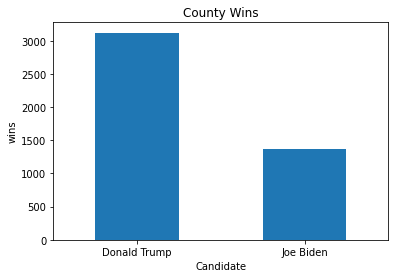

In [61]:
ax = wins['won'].plot.bar(x='candidate', rot=0, xlabel='Candidate', ylabel='wins', title='County Wins')

## 6.2 - Assess Total Votes

In [62]:
df.sort_values('total_votes', ascending=False)

,state,county,candidate,party,total_votes,won
28871,California,Los Angeles County,Joe Biden,DEM,3020546,True
1664,Illinois,Cook County,Joe Biden,DEM,1714792,True
28872,California,Los Angeles County,Donald Trump,REP,1142225,False
31401,Arizona,Maricopa County,Joe Biden,DEM,1040774,True
31402,Arizona,Maricopa County,Donald Trump,REP,995665,False
...,...,...,...,...,...,...
13976,New Hampshire,Millsfield,Joe Biden,DEM,5,False
13947,New Hampshire,Dixville,Joe Biden,DEM,5,True
14008,New Hampshire,Wentworth's Location,Joe Biden,DEM,4,False
19699,Texas,Loving County,Joe Biden,DEM,4,False


Show scatter plots

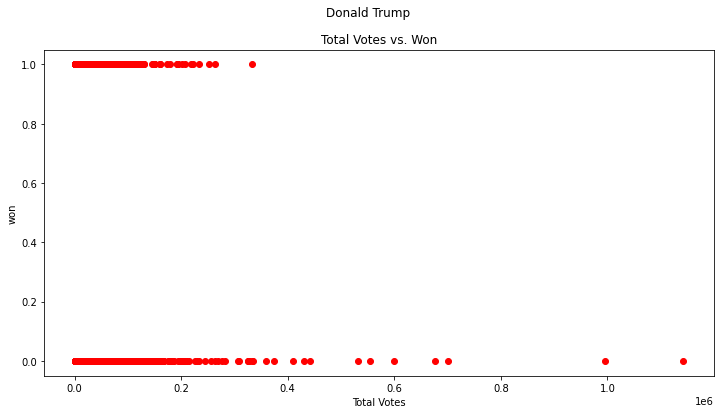

In [63]:
plt.figure(figsize=(12, 6))
plt.scatter(trump.total_votes, trump.won, color='r')
plt.xlabel('Total Votes')
plt.ylabel('won')
plt.suptitle('Donald Trump')
plt.title('Total Votes vs. Won')
plt.show()

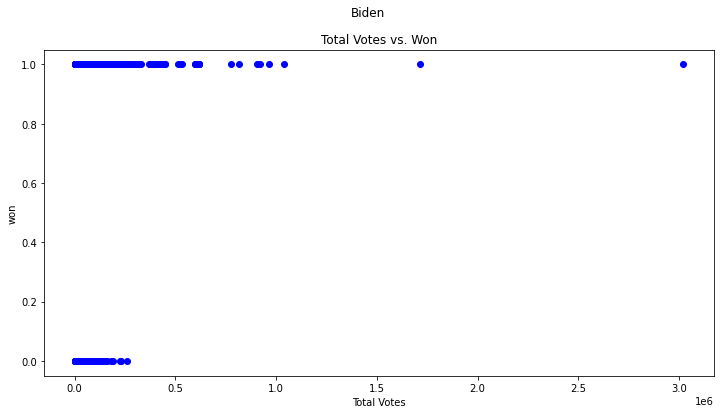

In [64]:
plt.figure(figsize=(12, 6))
plt.scatter(biden.total_votes, biden.won, color='b')
plt.xlabel('Total Votes')
plt.ylabel('won')
plt.suptitle('Biden')
plt.title('Total Votes vs. Won')
plt.show()

Display a Plotly Express scatter matrix

In [65]:
fig = px.scatter_matrix(df, dimensions=["total_votes", "won"])
fig.show()

Show a Plotly Express scatter plot indicating the mix of Biden and Trump votes

In [66]:
fig = px.scatter(df, x='total_votes', labels={'x':'Total Votes'}, color='candidate', hover_data=['candidate','state','county','won'])
fig.show()

This chart shows Biden had some large victories in some counties.

Show histogram

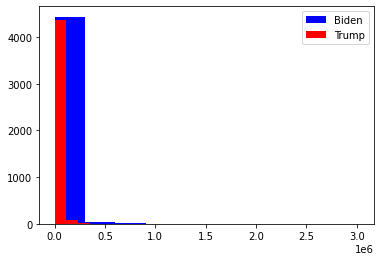

In [67]:
bins = 10
plt.hist(biden.total_votes, bins, alpha=1, color='blue', label='Biden')
plt.hist(trump.total_votes, bins, alpha=1, color='red', label='Trump')
plt.legend(loc='upper right')
plt.show()

This chart shows Biden had a wider spread ot total votes than Trump.

# 6 - Merge Biden and Trump Dataframes

In [68]:
merged_df = pd.merge(trump, biden, on=['state','county'])
merged_df.sample(3)

,state,county,candidate_x,party_x,total_votes_x,won_x,candidate_y,party_y,total_votes_y,won_y
4111,Arkansas,Craighead County,Donald Trump,REP,25558,True,Joe Biden,DEM,11921,False
3174,Texas,Caldwell County,Donald Trump,REP,8031,True,Joe Biden,DEM,6672,False
3591,Vermont,Worcester,Donald Trump,REP,125,False,Joe Biden,DEM,464,True


In [69]:
merged_df.rename(columns = {'total_votes_x':'trump_votes',
                            'won_x':'trump_win',
                            'total_votes_y':'biden_votes',
                            'won_y':'biden_win'}, 
                 inplace = True) 
merged_df.drop(columns=['candidate_x','party_x','candidate_y','party_y'], inplace=True)
merged_df.sample(5)

,state,county,trump_votes,trump_win,biden_votes,biden_win
3017,South Dakota,Hughes County,5522,True,2953,False
2137,New Hampshire,Tilton,1044,True,938,False
478,Indiana,Whitley County,12856,True,4233,False
846,Louisiana,St. Bernard Parish,11179,True,6151,False
4028,Alabama,Lamar County,6168,True,978,False


In [70]:
merged_df['vote_diff'] = merged_df['trump_votes'] - merged_df['biden_votes']
merged_df.sample(3)

,state,county,trump_votes,trump_win,biden_votes,biden_win,vote_diff
1037,Maine,Union,786,True,726,False,60
4378,Connecticut,Bridgewater,549,False,667,True,-118
3282,Texas,Kinney County,1144,True,446,False,698


# 7 - Demonstrate LLN Using Votes Data

## 7.1 - Randomly Select 20 observations


In [88]:
samples = merged_df.sample(20)
samples

,state,county,trump_votes,trump_win,biden_votes,biden_win,vote_diff
1633,Michigan,Kalkaska County,7436,True,3002,False,4434
4311,Connecticut,Plainfield,4080,True,2849,False,1231
2069,Nebraska,Kimball County,1563,True,268,False,1295
2086,Nebraska,Pierce County,3462,True,480,False,2982
902,Maine,Linneus,411,True,93,False,318
972,Maine,Brooksville,219,False,450,True,-231
1030,Maine,Hope,443,False,653,True,-210
3853,West Virginia,Cabell County,21721,True,14994,False,6727
1532,Massachusetts,Boston,42707,False,225368,True,-182661
3172,Texas,Burleson County,6743,True,1788,False,4955


In [89]:
# Display the mean Trump votes of these observations. 
sample_mean_votes_trump = int(samples['trump_votes'].mean())
sample_mean_votes_trump

9772

In [90]:
# Display the difference between this mean and the population mean for Trump votes.
pop_mean_votes_trump - sample_mean_votes_trump

6742

In [91]:
# Display the mean Biden votes of these observations. 
sample_mean_votes_biden = int(samples['biden_votes'].mean())
sample_mean_votes_biden

16031

In [92]:
# Display the difference between this mean and the population mean for Trump votes.
pop_mean_votes_biden - sample_mean_votes_biden

1892

Note these mean differences are pretty far off for both Trump and Biden

## 7.2 - Define Mean Difference Function
Takes two input parameters:

- x (number of observations)
- y (the name of the dataframe).

Performs the following for both Trump and Biden data:

- Randomly select x observations from y
- Calculate the mean votes of these x observations for each candidate
- Calculate the difference between the means and their respective population means
- Return the differences

In [93]:
def diff_sample_mean_from_population_mean(x, y, pop_mean_trump, pop_mean_biden):
    
    # Randomly select x observations from y
    samples = y.sample(x)

    # Calculate the mean of these x observations
    sample_mean_trump = samples['trump_votes'].mean()
    sample_mean_biden = samples['biden_votes'].mean()

    # Calculate differences from population means
    diff_trump = int(sample_mean_trump - pop_mean_trump)
    diff_biden = int(sample_mean_biden - pop_mean_biden)

    # Calculate and return the difference between the two means
    return diff_trump, diff_biden

Test Difference Function

In [95]:
# Test the function by passing a sample size and the name of the dataframe
sample_size = 4000
diff_trump, diff_biden = diff_sample_mean_from_population_mean(sample_size, merged_df, pop_mean_votes_trump, pop_mean_votes_biden)
print(diff_trump, diff_biden)

81 366


## 7.3 - Plot Mean Differences for 2000 Samples

In [103]:
# 1000 sample sizes
sequence_size = 2000
sample_sizes = [i for i in range(1, sequence_size + 1)]
means_diff_trump = []
means_diff_biden = []
for size in sample_sizes:

    # Obtain a random sample of that size from the dataframe
    # Calculate the sample mean 
    # Calculate the difference between the population mean and the sample mean
    diff_trump, diff_biden = diff_sample_mean_from_population_mean(size, merged_df, pop_mean_votes_trump, pop_mean_votes_biden)

    # Append the difference to the list "means_diff"
    means_diff_trump.append(diff_trump)
    means_diff_biden.append(diff_biden)

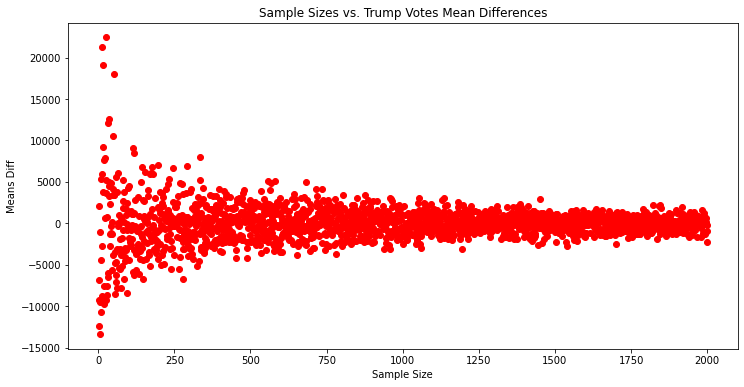

In [104]:
# Display Trump Scatter Plot    
plt.figure(figsize=(12, 6))
plt.scatter(sample_sizes, means_diff_trump, color='r')
plt.xlabel('Sample Size')
plt.ylabel('Means Diff')
plt.title('Sample Sizes vs. Trump Votes Mean Differences')
plt.show()

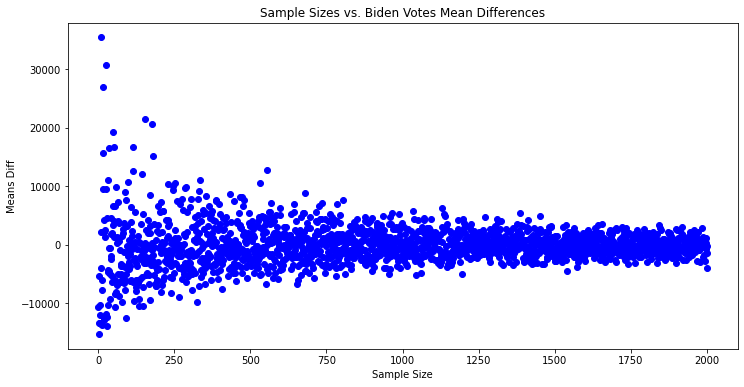

In [105]:
# Display Biden Scatter Plot    
plt.figure(figsize=(12, 6))
plt.scatter(sample_sizes, means_diff_biden, color='b')
plt.xlabel('Sample Size')
plt.ylabel('Means Diff')
plt.title('Sample Sizes vs. Biden Votes Mean Differences')
plt.show()

As the sample sizes increase, the mean differences converge toward zero for both Biden and Trump data.  

This demonstrates the Law of Large Numbers.